# Machine Learning Lab

This project aims at comparing the efficiency of Convolutional Neural Networks (CNN) with respect to Random Forest (RF) algorithms for the classification of data in the MNIST-fashion dataset.

We use PCA dimension reduction.

### Summary
The results of the project are delivered in this Jupyter Notebook as code cells that run the algorithms and markdown cells in order to provide comments. Both algorithms are imported from `classifiers.py` where the user can find the code.

In [1]:
from classifiers import CNN, RandomForest

 Both algorithms will follow this workflow:
 
1. load dataset
2. partition the dataset into a training and a test subsets
3. implement PCA
4. create a model (NN or forest)
5. train the model with the training subset
6. evaluate performances through the test subset

It is quite natural to implement the algorithms as subclasses that inherit most of their methods from a common parent class. In `classifiers.py` the user will find both the parent abstract class and the two sons. Since the user's primary goal is point 6, there is no need to call methods 1 to 5 in this Notebook: the code is structured such that a method called `evaluate` will return every goodness-of-fit indicator and run points 1 to 5 itself with help from che class constructor and a data-loading class in `data_loader.py`.

## Convolutional Network

### Architecture
The CNN is built as follows:

1. `Conv2D(kernel_size=5)`
    - `MaxPooling2D`
    - `Dropout`
1. `Conv2D(kernel_size=3)`
    - `MaxPooling2D`
    - `Dropout`
3. `Flatten`
4. `Dense`

Both convolutional layers have `relu` as activation function: this is quite common when dealing with CNNs. The final dense layer has `softmax`. The loss function is categorical cross-entropy: this is also common for CNNs.
Every other parameter of the network has to be stated by the user in a dictionary as input when the object is created. We shall use the following configuration.

In [2]:
optimizers = ['SGD', 'Adam', 'RMSprop', 'Adagrad', 'Adamax', 'Nadam']
config_dicts = [{
    'epochs': 5,
    'dropout': 0.2,
    'batch_size': 32,
    'optimizer': optimizer,
} for optimizer in optimizers]

It is quite useful to check the behavior of the network with different optimizers and we implement such hyperparameter tuning in what follows, both with and without PCA.

In [3]:
from tensorflow import keras
%time neuralnets = [CNN(keras.datasets.fashion_mnist, config_dict) for config_dict in config_dicts]

CPU times: user 6.12 s, sys: 1.36 s, total: 7.47 s
Wall time: 7.48 s


In [4]:
%time neuralnets_pca = [CNN(keras.datasets.fashion_mnist, config_dict, pca_percent=0.95) for config_dict in config_dicts]

CPU times: user 1min 42s, sys: 13.6 s, total: 1min 55s
Wall time: 1min 16s


Note that when PCA is enabled, initialization takes more time since we want the numer of eigenvalues up to which 95% of the variance is estimated. This requires diagonalization of the covariance matrix of the data and is computationally non negligible. However, the same calculation is performed for all hyperparameters, so in principle one could do it only once and store data somewhere in order to avoid doing it several times.


With the following line we build, train and test the networks and get their evaluation parameters as a tuple. We refer the user to the documentation of the `evaluate` method for precise indications on how results are stored in the tuple.

In [5]:
cnn_scores = [neuralnet.evaluate() for neuralnet in neuralnets]

In [6]:
cnn_scores_pca = [neuralnet.evaluate() for neuralnet in neuralnets_pca]

### Loss and accuracy per epoch

The plot below represents the performance of the various optimizers as more epochs have passed during the training of the neural network.
There are two main reasons why this plot should always be considered in a efficiency report like this: first, one can easily check the trend of the curves and learn how quick the NN learns with different optimizers. Secondly, the curves might tell that the number of epochs is insufficient and the NN needs more time to reach stability.

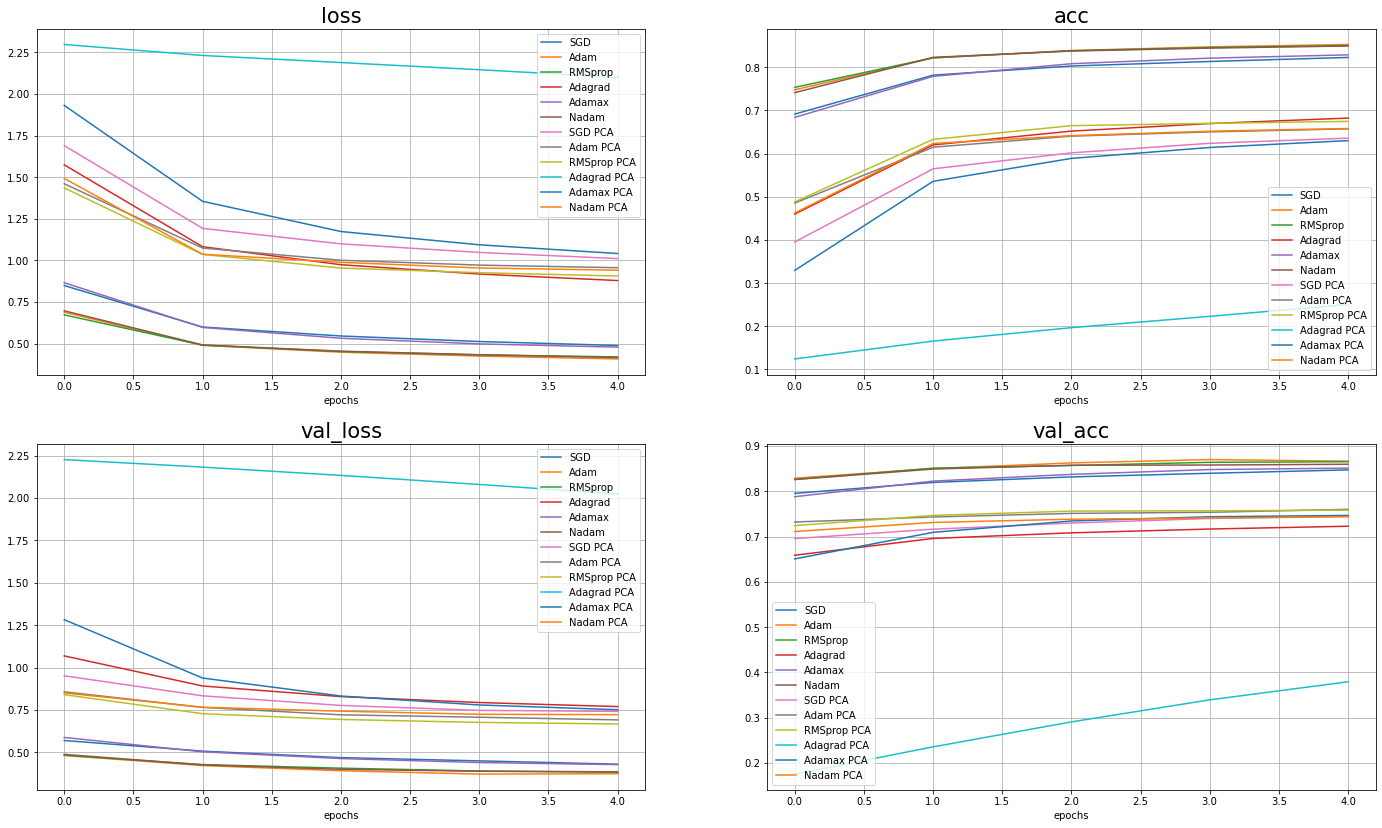

In [7]:
import matplotlib.pyplot as plt
indicators = ['loss', 'acc', 'val_loss', 'val_acc']
fig, axs = plt.subplots(2, 2, figsize=(24,14))
for ax, indicator in zip(axs.flatten(), indicators):
    ax.set_title(indicator, fontsize=21)
    ax.set_xlabel('epochs')
    ax.grid(True)
    for score in cnn_scores:
        score_dict, _, history = score
        ax.plot(history.history[indicator], label=score_dict['Optimizer'])
        ax.legend()
    for score in cnn_scores_pca:
        score_dict, _, history = score
        ax.plot(history.history[indicator], label=score_dict['Optimizer']+' PCA')
        ax.legend()

Observe that `Adagrad` seems to perform worse than the other optimizers, which improve their accuracy way faster (or are already way more accurate in the first epochs).
The overall trend of the curves suggests that the number of epochs chosen is enough and stability is reached for the best-performing optimizers.

Observe that the CNN trained on the whole dimensions seem to outperform the PCA-reduced CNNs. We therefore discard PCA in the future comparisons with RFs.

### Performance table for non-reduced CNNs

We show here the table with the overall performance of the CNN for different optimizers. Note that, at its best, the network functions with circa 85% of accuracy.

In [8]:
import pandas as pd
cnn_dataframes = []
for score in cnn_scores:
    score_dict, _, _ = score
    df = pd.DataFrame.from_dict(score_dict, columns=[score_dict['Optimizer']], orient='index').drop('Optimizer')
    cnn_dataframes += [df]
aa = pd.concat(cnn_dataframes, axis=1)
display(aa)

,SGD,Adam,RMSprop,Adagrad,Adamax,Nadam
Loss,0.4307,0.3743,0.3833,0.7700,0.4279,0.3856
Accuracy,0.8473,0.8665,0.8653,0.7229,0.8512,0.8597


## Random Forest

A random forest (RF) is an ensemble of decision trees whose output, in a classification task, is the class selected by most trees.

In this work, each decision tree is trained on various bootstrap subsamples of the training dataset. In what follows, we are going to train several forests with different sub-sample sizes (the list `samples` contains the fractions of the total training dataset used). We also test performance with a logarithmically increasing number of trees in the ensemble, as one can see in `estimators`).

In [18]:
estimators = [10, 100, 200, 500]
samples = [0.01, 0.1, 0.2, 0.5, 1.]

We use `itertools.product` in order to search all the hyperparameter space defined by the lists above.

We use `itertools.product` in order to search all the hyperparameter space defined by the lists above.

In [19]:
from itertools import product
config_tuple = product(estimators, samples)
config_rf_dicts = [{
    'n_estimators': int(n_estimators),
    'criterion': 'entropy',
    'max_samples': float(max_samples)
} for n_estimators, max_samples in config_tuple]

Please note that initialization of RF classifiers takes time since it has to determine how many principal components contribute to 90% of the variance of data. Each of the 20 RF object is doing the same calculation over again. Hyperparameter tuning is something that takes time, but we do not account for this time in performance evaluation since the hyperparameters are tuned only once.

Please note that initialization of RF classifiers takes time since it has to determine how many principal components contribute to 90% of the variance of data. Each of the 20 RF object is doing the same calculation over again. Hyperparameter tuning is something that takes time, but we do not account for this time in performance evaluation since the hyperparameters are tuned only once.

We plot the accuracy in hyperparameter space.

We plot the accuracy in hyperparameter space.

Observe that PCA-RF reaches good accuracies when the number of trees is reasonable (not 10).

## Comparison

In order to compare the performance of the two classfication methods, we need to define what is meant for good performance of a method.
Of course, a well-performing method is one that is accurate within the validation dataset and can, therefore, predict any new input with enough precision.
On the other hand, we would like such method to be able to run in a reasonable amount of time within the resources it used.

### Model building

We build two models, one CNN and one RF, that will be compared in the following cells. For the CNN, we choose the better-performing optmizer (Nadam), while for the RF classifier we choose big boostrap samples (80% of data) and a high number of trees.

In [14]:
# CNN
# config dict
comparison_config_cnn = {
    'epochs': 5,
    'dropout': 0.2,
    'batch_size': 32,
    'optimizer': 'Nadam',
}
# model build
comparison_cnn = CNN(keras.datasets.fashion_mnist, comparison_config_cnn)
# RANDOM FOREST
# config dict
comparison_config_rf = {
    'n_estimators': 200,
    'criterion': 'entropy',
    'max_samples': 0.8
}
# model build
comparison_rf = RandomForest(keras.datasets.fashion_mnist, comparison_config_rf, pca_percent=0.9)

### Resources used

In what follows, we run the ```evaluate``` method for the two models and store their times.
Note that there are three different times here:

1. The ```Wall time``` is the time measured by a clock outside the CPU, discard any relativistic effect since we are not travelling at $v\simeq c$ :). It is the actual time the method took to run.

2. The ```CPU times``` refer to the total execution time of the process. It is composed by the ```user``` time (the process CPU time) and ```sys``` time (the operating system CPU time due to system calls from the process).

The wall time can be less than CPU's when multiple processors are used. This is not a feature of our code, but it can still happen due to some library that uses multiple processors for the tasks we require them. Indeed, the RF classifier used here from `sklearn` features the possibility of setting `n_jobs=-1`, thus using all the available cores.

In [15]:
%time comparison_cnn_score = comparison_cnn.evaluate()

CPU times: user 4min 53s, sys: 3min 33s, total: 8min 27s
Wall time: 2min 22s


In [16]:
%time comparison_rf_score = comparison_rf.evaluate()

CPU times: user 7min 26s, sys: 860 ms, total: 7min 27s
Wall time: 1min 58s


The differences here are subtle. First of all, we observe that RF takes less wall time compared to a CNN classifier.

The CPU times are also comparable (with slight outperforming of the RF), but there are huge differences in how it is distributed between sys and user. The fact that sys time (CPU time spent in system calls within the kernel) is nonzero for CNNs may indicate that the kernel code is not optimized, or that CNNs require more kernel operations (meaning that libraries provide partial results, or results that must be linked to each other within the kernel in order to produce an output).

### Accuracy

In this final section we aim at comparing efficiency of CNNs and RFs through their precision. This is done by plotting the confusion matrix of the test dataset.

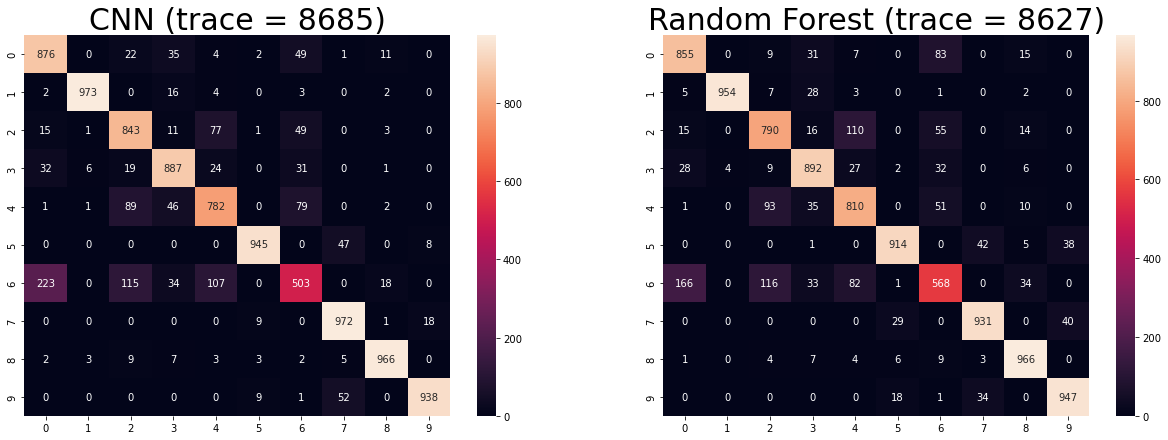

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(21, 7))
import seaborn as sns
for ax, cm, title in zip(axs, (comparison_cnn_score[1], comparison_rf_score[0]), ['CNN', 'Random Forest']):
    ax.set_title(title + ' (trace = ' + str(cm.trace()) + ')', size=30)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)

The accuracy of the models can be read off the trace: it is 86% for both cases.

## Conclusions

We conclude that the choice of a CNN over a RF (and vice-versa) for image classification depends on the situation. 

As one could sense from the theoretical definition of such classifiers, RF is simpler and in fact requires almost no time within the kernel to be executed. This means that, if libraries are well optimized, results will come in a reasonable amount of wall time with a great accuracy.

On the other hand, kernel time used on the CNN approach suggests that the code can be optimized further. This can be done by changing the architecture of the neural network. One must keep in mind that less parameters yield a reduction of both CPU used and performance, i.e. of accuracy. The tradeoff between accuracy and computational expense must be treated carefully.